In [1]:
from src.classification.pre_process import *
from sklearn.svm import SVC
import joblib
import os
from sklearn.preprocessing import StandardScaler

In [2]:
# Classification Training
X_train, X_test, y_train, y_test = processClassificationTrain('./data/TrainDataset2024.xls')

Epoch [10/50], Loss: 0.6269
Epoch [20/50], Loss: 0.4109
Epoch [30/50], Loss: 0.2570
Epoch [40/50], Loss: 0.1329
Epoch [50/50], Loss: 0.0412
Accuracy: 0.89

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.93      0.84      0.89        64
     Class 1       0.86      0.94      0.89        63

    accuracy                           0.89       127
   macro avg       0.89      0.89      0.89       127
weighted avg       0.89      0.89      0.89       127



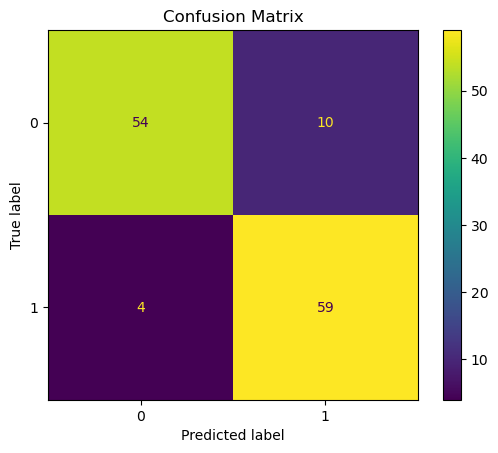

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import joblib
import os
import seaborn as sns
import matplotlib.pyplot as plt

# scaler = joblib.load('./src/models/data_preprocessing/scaler.joblib')

# scaler_path = './src/models/data_preprocessing/scaler.joblib'
# scaler = StandardScaler()

# # Scale the data
# X_train_scaled = scaler.fit_transform(X_train)
# joblib.dump(scaler, scaler_path)
# X_test_scaled = scaler.transform(X_test)

# Convert numpy arrays to tensors
X_train_tensor = torch.from_numpy(X_train.to_numpy()).float()
X_test_tensor = torch.from_numpy(X_test.to_numpy()).float()
y_train_tensor = torch.from_numpy(y_train.to_numpy()).long()
y_test_tensor = torch.from_numpy(y_test.to_numpy()).long()

# Define the neural network model with even more layers
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(X_train_tensor.shape[1], 128)  # input layer (784) -> hidden layer (128)
        self.fc2 = nn.Linear(128, 128)  # hidden layer (128) -> hidden layer (128)
        self.fc3 = nn.Linear(128, 128)  # hidden layer (128) -> hidden layer (128)
        self.fc4 = nn.Linear(128, 128)  # hidden layer (128) -> hidden layer (128)
        self.fc5 = nn.Linear(128, 128)  # hidden layer (128) -> hidden layer (128)
        self.fc6 = nn.Linear(128, 2)  # hidden layer (128) -> output layer (2) (Binary classification)

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # activation function for hidden layer
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = self.fc6(x)
        return x

net = Net()

epochs = 50

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Train the network
for epoch in range(epochs):  # loop over the dataset multiple times
    optimizer.zero_grad()
    outputs = net(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:  # print every 100 mini-batches
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Make predictions
y_pred_tensor = net(X_test_tensor).argmax(dim=1)
y_pred = y_pred_tensor.cpu().numpy()

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Classification report for precision, recall, and F1-score
print("\nClassification Report:")
report = classification_report(y_test, y_pred, target_names=[f"Class {i}" for i in range(len(set(y_train)))])
print(report)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()

plt.title('Confusion Matrix')
plt.show()

# Save the model
os.makedirs('./src/models/classification', exist_ok=True)
torch.save(net.state_dict(), './src/models/classification/neural_network_model.pth')

In [4]:
_, X_test, _, y_test = processClassificationTest('./data/TestDatasetExample.xls')

In [5]:
def predict_new_data(test_file_path, model_path):
    """
    Preprocess new data and make predictions using a saved PyTorch model.
    """
    # Read original data to get IDs
    original_data = pd.read_excel(test_file_path)
    original_ids = original_data['ID'].values
    
    # Initialize pipeline for test data
    _, X_test, _, y_test = processClassificationTest(test_file_path)
    
    # Convert data to tensors
    X_test_tensor = torch.from_numpy(X_test.to_numpy()).float()
    
    # Load the saved PyTorch model
    model = Net()
    model.load_state_dict(torch.load(model_path, weights_only=True))
    model.eval()
    
    # Make predictions
    with torch.no_grad():
        predictions = model(X_test_tensor).argmax(dim=1)
    
    # Create results DataFrame
    results = pd.DataFrame({
        'ID': original_ids,
        'Predicted pCR (outcome)': predictions.cpu().numpy()
    })
    
    return results

# Make predictions on test data using the saved PyTorch model
predictions_df = predict_new_data('./data/TestDatasetExample.xls', './src/models/classification/neural_network_model.pth')
print("\nPredictions on Test Data:")
print(predictions_df)


Predictions on Test Data:
          ID  Predicted pCR (outcome)
0  TRG002728                        1
1  TRG002649                        1
2  TRG002628                        1
